# Installing the [Kaggle API](https://github.com/Kaggle/kaggle-api) in Colab

In [ ]:
!pip install kaggle

# Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


# Download Kaggle Covid-19 Datasets 

In [ ]:
# download
!kaggle datasets download -d hendratno/covid19-indonesia

  0% 0.00/130k [00:00<?, ?B/s]
100% 130k/130k [00:00<00:00, 45.2MB/s]


In [ ]:
# extract zip file
!unzip covid19-indonesia.zip

Archive:  covid19-indonesia.zip
  inflating: covid_19_indonesia_time_series_all.csv  


# Import Libraries
Basic data scientist toolkit and deep learning API

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop

import math, datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Load Datasets

In [ ]:
covid19 = pd.read_csv("covid_19_indonesia_time_series_all.csv", parse_dates=True)
covid19

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,3,0,0,3,501,20,39,442,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.28,46.19,0.00,1.84,3.99%,7.78%,NaN,NaN
1,3/1/2020,ID-JB,Jawa Barat,3,0,0,3,3,5,4,-6,Province,NaN,Jawa Barat,Indonesia,Asia,Jawa,UTC+07:00,NaN,18,9.0,627,645.0,5312.0,35378,45161325,1276.55,107.603708,-6.920432,0.07,0.07,0.00,0.11,166.67%,133.33%,NaN,NaN
2,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,503,20,39,444,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,46.38,0.00,1.84,3.98%,7.75%,0.67,1.0
3,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,2,Country,NaN,NaN,Indonesia,Asia,NaN,NaN,NaN,416,98.0,7230,8488.0,74953.0,1916907,265185520,138.34,113.921327,-0.789275,0.01,0.01,0.00,0.00,0.00%,0.00%,NaN,NaN
4,3/2/2020,ID-JB,Jawa Barat,0,0,0,0,3,5,4,-6,Province,NaN,Jawa Barat,Indonesia,Asia,Jawa,UTC+07:00,NaN,18,9.0,627,645.0,5312.0,35378,45161325,1276.55,107.603708,-6.920432,0.00,0.07,0.00,0.11,166.67%,133.33%,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,7/25/2020,ID-SG,Sulawesi Tenggara,17,0,1,16,752,13,402,337,Province,NaN,Sulawesi Tenggara,Indonesia,Asia,Sulawesi,UTC+08:00,NaN,15,2.0,219,377.0,1911.0,38068,2635461,69.23,122.070311,-4.124689,6.45,285.34,0.00,4.93,1.73%,53.46%,0.74,0.0
4364,7/25/2020,ID-SA,Sulawesi Utara,54,1,22,31,2216,120,1000,1096,Province,NaN,Sulawesi Utara,Indonesia,Asia,Sulawesi,UTC+08:00,NaN,11,4.0,171,332.0,1507.0,13892,2641884,190.17,124.521240,1.259638,20.44,838.80,0.38,45.42,5.42%,45.13%,1.29,NaN
4365,7/25/2020,ID-SB,Sumatera Barat,12,0,13,-1,863,33,727,103,Province,NaN,Sumatera Barat,Indonesia,Asia,Sumatera,UTC+07:00,NaN,12,7.0,179,230.0,928.0,42013,5519245,131.37,100.465062,-0.850253,2.17,156.36,0.00,5.98,3.82%,84.24%,4.00,1.0
4366,7/25/2020,ID-SS,Sumatera Selatan,17,0,29,-12,3228,147,1604,1477,Province,NaN,Sumatera Selatan,Indonesia,Asia,Sumatera,UTC+07:00,NaN,13,4.0,241,387.0,2853.0,91592,8217551,89.72,104.169465,-3.216212,2.07,392.82,0.00,17.89,4.55%,49.69%,0.37,0.0


In [ ]:

# Check missing values in datasets
covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         4368 non-null   object 
 1   Location ISO Code            4368 non-null   object 
 2   Location                     4368 non-null   object 
 3   New Cases                    4368 non-null   int64  
 4   New Deaths                   4368 non-null   int64  
 5   New Recovered                4368 non-null   int64  
 6   New Active Cases             4368 non-null   int64  
 7   Total Cases                  4368 non-null   int64  
 8   Total Deaths                 4368 non-null   int64  
 9   Total Recovered              4368 non-null   int64  
 10  Total Active Cases           4368 non-null   int64  
 11  Location Level               4368 non-null   object 
 12  City or Regency              0 non-null      float64
 13  Province          

In [ ]:
# Extract only date and numeric values
timeseries = covid19[pd.Index(["Date"]).append(covid19.select_dtypes("int64").columns)].copy()
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                4368 non-null   object
 1   New Cases           4368 non-null   int64 
 2   New Deaths          4368 non-null   int64 
 3   New Recovered       4368 non-null   int64 
 4   New Active Cases    4368 non-null   int64 
 5   Total Cases         4368 non-null   int64 
 6   Total Deaths        4368 non-null   int64 
 7   Total Recovered     4368 non-null   int64 
 8   Total Active Cases  4368 non-null   int64 
 9   Total Regencies     4368 non-null   int64 
 10  Total Districts     4368 non-null   int64 
 11  Area (km2)          4368 non-null   int64 
 12  Population          4368 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 443.8+ KB


# Resample DataFrame into daily
The data itself has daily timeframe, but it separated by the location resulting in multiple rows with same date. We need to resample it back into a single daily

In [ ]:
# Convert Date column to DateTimeIndex
timeseries["Date"] = pd.to_datetime(timeseries["Date"])

# Convert Date column to Index
timeseries.set_index("Date", inplace=True)

In [ ]:
resampled = timeseries.resample("1D").max()

# Create new Date column
resampled["Date"] = resampled.index

resampled.tail()

,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Total Regencies,Total Districts,Area (km2),Population,Date
Date,,,,,,,,,,,,,
2020-07-21,1655,81,1489,159,89869,4320,48466,37083,416,7230,1916907,265185520,2020-07-21
2020-07-22,1882,139,1789,136,91751,4459,50255,37037,416,7230,1916907,265185520,2020-07-22
2020-07-23,1906,117,1909,305,93657,4576,52164,36917,416,7230,1916907,265185520,2020-07-23
2020-07-24,1761,89,1781,72,95418,4665,53945,36808,416,7230,1916907,265185520,2020-07-24
2020-07-25,1868,49,1409,410,97286,4714,55354,37218,416,7230,1916907,265185520,2020-07-25


# Plot Total Cases Data
Explore information that the data yield. This is important to understand patterns in data.

In [ ]:
from collections import namedtuple

# Create a list of namedtuples
Plot = namedtuple("Plot", "Parameter Color")
features = ["Total Cases", "Total Recovered",  "Total Deaths"]
colors = ["tomato", "lightgreen", "indigo"]

info = [Plot(feature, color) for feature, color in zip(features, colors)]
info

[Plot(Parameter='Total Cases', Color='tomato'),
 Plot(Parameter='Total Recovered', Color='lightgreen'),
 Plot(Parameter='Total Deaths', Color='indigo')]

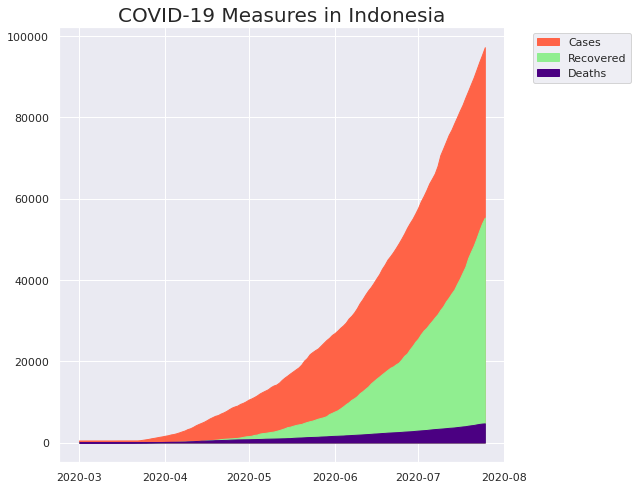

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("COVID-19 Measures in Indonesia", fontdict={"size": 20})

# plot data
for parameter, color in info:
  plt.fill_between(resampled["Date"], resampled[parameter], 
                   color=color, label=parameter.split()[1])

# legends
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

# Preparing Data
Before we put our data into deep learning model, we need to specify what samples and targets that we gonna use.

- Samples are timeseries data which is 3D Tensor containing samples, timesteps and features.

- Target is 1D vector of future cases.

Then, the data need to be formated so that neural network can digest.

## Feature Extraction
There are many features that we can get, but I need only 1 feature: Current total cases

In [ ]:
# Features are cases, deaths and recovered
data = resampled["Total Cases"].copy()
data.shape

(147,)

## Problem Formulation for Predicting Future Cases
Before commiting time series prediction, we need to specify how far the future value that'll be forecasted from the current time.

In this session, try predicting how many total cases on the next day, using these 3 variables:

In [ ]:
lookback = 1 # Observation will go back 1 day
steps = 1 # Observation will be sampled at one data point per day
delay = 1 # Targets will be 1 day in the future

## Normalizing Data
We'll normalize our data to a format which neural network can digest. 

Your whole training data length is N - lookback - 2, leaving the 2 remainders of data for validating and testing.

***Note: We use the values from training data to perform scaling in order to avoid data leakage.***

In [ ]:
# Use training data to scale validation data
mean = data[:lookback - 2].mean(axis=0)
std = data[:lookback - 2].std(axis=0)

# Function to normalize data
def normalize(data, mean, std):
    data -= mean
    data /= std
    return data

data = normalize(data, mean, std)

In [ ]:
def generate_data(data, lookback, delay, steps=1):
    length = len(data) - max(lookback, delay)

    samples = np.zeros(shape=(length, lookback // steps, data.shape[-1]))
    targets = np.zeros(shape=(length,))

    for i in range(length):
        samples[i] = data[i]
        targets[i] = data[i + delay]

    return samples, targets

# Convert data frame to numpy
npdata = data.to_numpy()
if len(npdata.shape) == 1:
    npdata = npdata.reshape(-1, 1)
    
samples, targets = generate_data(npdata, lookback, delay, steps)

## Split Data
We used all of the data for training except the last 2 index for validating and testing.

In [ ]:
# Extract training data, the rest is for validation and test
train_x, train_y = samples[:-2], targets[:-2]

# Split validation data and test data
valid_x, valid_y = samples[-2:-1], targets[-2:-1]
test_x, test_y = samples[-1:], targets[-1:]

# Building Simple Machine Learning Model
Before using a computationally expensive models like RNN, it is advised to use simple and cheap machine learning model like a small densely connected network.

This'll ensure how important any further more complex approach is and will deliver real benefits.

In [ ]:
model = Sequential()
model.add(layers.Flatten(input_shape=(steps, samples.shape[-1])))
model.add(layers.Dense(32, input_shape=(steps, samples.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model Checkpoint and Early Stopping
# Automatically stop training process when there was no improvement on val_loss
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor="val_loss",
                      patience=1
                  ),
                  keras.callbacks.ModelCheckpoint(
                      filepath="good_model.h5",
                      monitor="val_loss",
                      save_best_only=True
                  )
]

In [ ]:
model.compile(optimizer="rmsprop", loss="mae")

history = model.fit(train_x, train_y, 
                    epochs=100,
                    batch_size=16,
                    callbacks=callbacks_list,
                    validation_data=(valid_x, valid_y)
                )

Train on 144 samples, validate on 1 samples
Epoch 1/100
144/144 [==============================] - 0s 2ms/step - loss: 0.7881 - val_loss: 2.3700
Epoch 2/100
144/144 [==============================] - 0s 107us/step - loss: 0.6529 - val_loss: 2.1107
Epoch 3/100
144/144 [==============================] - 0s 111us/step - loss: 0.5536 - val_loss: 1.8526
Epoch 4/100
144/144 [==============================] - 0s 104us/step - loss: 0.4626 - val_loss: 1.5797
Epoch 5/100
144/144 [==============================] - 0s 120us/step - loss: 0.3790 - val_loss: 1.2960
Epoch 6/100
144/144 [==============================] - 0s 101us/step - loss: 0.2967 - val_loss: 1.0012
Epoch 7/100
144/144 [==============================] - 0s 94us/step - loss: 0.2161 - val_loss: 0.6726
Epoch 8/100
144/144 [==============================] - 0s 99us/step - loss: 0.1350 - val_loss: 0.3418
Epoch 9/100
144/144 [==============================] - 0s 103us/step - loss: 0.0538 - val_loss: 0.0295
Epoch 10/100
144/144 [===========

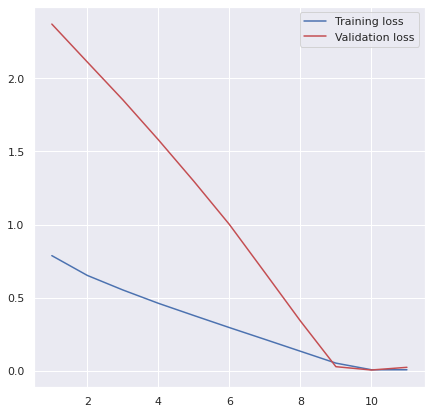

In [ ]:
# Plot training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(7, 7))
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.legend();

In [ ]:
eval_loss = model.evaluate(test_x, test_y)
eval_loss

1/1 [==============================] - 0s 1ms/step


0.02301764488220215

In [ ]:
# Denormalize mae to actual value
cases_mae = eval_loss * std
cases_mae

627.046329391872

***Estimation error here is 632 (may differ with your result), which is  high for estimating future cases, hence we need more complex and powerful model to handle sequential data***

# Switching to Recurrent Neural Network

In [ ]:
strong_model = Sequential()
strong_model.add(layers.LSTM(32, return_sequences=True, 
                             input_shape=(None, samples.shape[-1]),))
strong_model.add(layers.LSTM(16))
strong_model.add(layers.Dense(1))

strong_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model Checkpoint and Early Stopping
callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor="val_loss",
                      patience=10
                  ),
                  keras.callbacks.ModelCheckpoint(
                      filepath="strong_model.h5",
                      monitor="val_loss",
                      save_best_only=True
                  )
]

In [ ]:
strong_model.compile(optimizer="rmsprop", loss="mae")

history = strong_model.fit(train_x, train_y, 
                            epochs=100,
                            batch_size=1,
                            callbacks=callbacks_list,
                            validation_data=(valid_x, valid_y)
                    )

Train on 144 samples, validate on 1 samples
Epoch 1/100
144/144 [==============================] - 1s 9ms/step - loss: 0.0154 - val_loss: 0.0267
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.1150
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0450
Epoch 4/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.1138
Epoch 5/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0878
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0535
Epoch 7/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0617
Epoch 8/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0129 - val_loss: 0.0513
Epoch 9/100
144/144 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0389
Epoch 10/100
144/144 [=========================

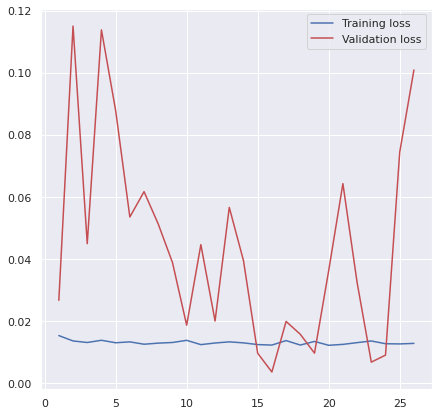

In [ ]:
# Plot training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(7, 7))
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.legend();

In [ ]:
# Load best model from model checkpoint
from keras.models import load_model
best_model = load_model("strong_model.h5")

eval_loss = best_model.evaluate(test_x, test_y)
eval_loss

1/1 [==============================] - 0s 74ms/step


0.0069980621337890625

In [ ]:
# Denormalize mae to actual value
cases_mae = eval_loss * std
cases_mae

190.64110148131118

***The change may be not significant between models, but this LSTM model slightly better than those simple flattening model.***

# Predict Future Total Cases

In [ ]:
# Invers Transform current day value (multiply by std and add by mean)
current_day = (test_y * std) + mean
current_day

array([97286.])

In [ ]:
next_day = best_model.predict(test_y.reshape(1, 1, 1))

# Invers Transform next day value (multiply by std and add by mean)
next_day = (next_day * std) + mean

# Summarize your result
today = datetime.date.today()

print("Current total cases in {}:\n{}"\
            .format(today, current_day[0]), end="\n\n")

print("Estimated total cases COVID-19 in Indonesia in the next day is:\n{}"\
            .format(next_day[0,0]), end="\n\n")

print("Difference:\n{}".format(abs(next_day - current_day)[0,0]))

Current total cases in 2020-07-26:
97286.0

Estimated total cases COVID-19 in Indonesia in the next day is:
98740.3828125

Difference:
1454.3828125
